In [1]:
import math
import json
import os
import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta, time
from research.utils.data_access_utils import RDSAccessUtils
from research.weight_estimation.keypoint_utils.optics import euclidean_distance, pixel2world, depth_from_disp, convert_to_world_point
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

rds_access_utils = RDSAccessUtils(json.load(open(os.environ['DATA_WAREHOUSE_SQL_CREDENTIALS'])))

In [3]:
pen5 = pd.read_csv('/root/data/bryton/blom_vikane_singleweights.csv')

In [4]:
pen5['weight']

0        2.58
1        3.63
2        2.03
3        3.83
4        3.27
         ... 
46345    2.82
46346    2.96
46347    3.59
46348    2.64
46349    2.75
Name: weight, Length: 46350, dtype: float64

In [8]:
queryCache = {}

In [146]:
def getPenDF(pen):
    akpd_filter = 0.95

    query = """
       SELECT * FROM prod.biomass_computations
        WHERE prod.biomass_computations.captured_at >= '%s'
        AND prod.biomass_computations.captured_at <= '%s'
        AND prod.biomass_computations.akpd_score > %0.4f
        AND prod.biomass_computations.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], akpd_filter, pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
#     depths = []
#     for idx, row in df.iterrows():
#         ann, cm = row.annotation, row.camera_metadata
#         wkps = pixel2world(ann['leftCrop'], ann['rightCrop'], cm)
#         depth = np.median([wkp[1] for wkp in wkps.values()])
#         vector = wkps['UPPER_LIP'] - wkps['TAIL_NOTCH']
#         depths.append(depth)
#     df['depth'] = depths
    
    return df


In [362]:
def getQualityDF(pen):
    query = """
       SELECT left_crop_metadata, right_crop_metadata, captured_at FROM prod.crop_annotation 
        WHERE prod.crop_annotation.captured_at >= '%s'
        AND prod.crop_annotation.captured_at <= '%s'
        AND prod.crop_annotation.pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()

    df = df.sort_values('captured_at').copy(deep=True)
    df.index = pd.to_datetime(df.captured_at)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
    
    return df


In [25]:
pen = {
    'pen_id': 60,
    'start_date': '2020-08-01 00:00',
    'end_date': '2020-08-26 00:00'
}

df1 = getPenDF(pen)


In [147]:
pen = {
    'pen_id': 60,
    'start_date': '2020-06-01 00:00',
    'end_date': '2020-08-26 00:00'
}

df1 = getPenDF(pen)


In [363]:
pen = {
    'pen_id': 60,
    'start_date': '2020-06-01 00:00',
    'end_date': '2020-08-26 00:00'
}

qdf1 = getQualityDF(pen)


In [365]:
def add_quality_fields(qdf1):
    quality_score = []
    single_quality_score = []
    combined_quality_score = []
    left_quality_score = []
    right_quality_score = []

    for index, row in qdf1.iterrows():
        qualityScore = 0
        count = 0

        if row['left_crop_metadata']:
            qualityScore = qualityScore + row['left_crop_metadata']['quality_score']
            left_quality_score.append(row['left_crop_metadata']['quality_score'])
            count = count + 1
        else:
            left_quality_score.append(None)

        if row['right_crop_metadata']:
            qualityScore = qualityScore + row['right_crop_metadata']['quality_score']
            right_quality_score.append(row['right_crop_metadata']['quality_score'])
            count = count + 1
        else:
            right_quality_score.append(None)

        if count > 0:
            quality_score.append(qualityScore / count)
        if count == 1:
            single_quality_score.append(qualityScore / count)
            combined_quality_score.append(None)
        if count == 2:
            single_quality_score.append(None)
            combined_quality_score.append(qualityScore / count)

    qdf1['quality_score'] = quality_score
    qdf1['single_quality_score'] = single_quality_score
    qdf1['combined_quality_score'] = combined_quality_score
    qdf1['left_quality_score'] = left_quality_score
    qdf1['right_quality_score'] = right_quality_score

add_quality_fields(qdf1)

In [230]:
prod_access_utils = RDSAccessUtils(json.load(open(os.environ['PROD_SQL_CREDENTIALS'])))

In [235]:
query = '''
    select * from event_logs where pen_id = 60
    and ended_at >= '2020-06-01'
    and started_at <= '2020-08-26' 
'''

edf = prod_access_utils.extract_from_database(query)

In [244]:


# for index, row in edf.iterrows():
edf.index = pd.to_datetime(edf.started_at)
start_dates = edf.index.date.astype(str)
edf['start_date'] = start_dates
edf['start_hour'] = edf.index.hour
edf.index = pd.to_datetime(edf.ended_at)
end_dates = edf.index.date.astype(str)
edf['end_date'] = end_dates
edf['end_hour'] = edf.index.hour

In [252]:
dates = sorted(list(set(df1['date'])))

event_name = []
start_hours = []
end_hours = []

for _, row in edf.iterrows():
    event_name.append(row['event_type'])
    for index, date in enumerate(dates):
        if row['start_date'] == date:
            start_hours.append(index * 24 + row['start_hour'])
        if row['end_date'] == date:
            end_hours.append(index * 24 + row['end_hour'])

In [148]:
def getSensorDF(pen):
    query = """
       SELECT * FROM stream.telemetry where ts >= '%s' and ts <= '%s' and pen_id = %i;
    """ % (pen['start_date'], pen['end_date'], pen['pen_id'])

    if query in queryCache:
        df = queryCache[query].copy()
    else:
        df = rds_access_utils.extract_from_database(query)
        queryCache[query] = df.copy()
        
    df.index = pd.to_datetime(df.ts)
    dates = df.index.date.astype(str)
    df['date'] = dates
    df['hour'] = df.index.hour
        
    return df

In [150]:
s1 = getSensorDF(pen)


In [151]:
s1.head()

,device_id,pen_id,ts_source,ts,attribute,value,date,hour
ts,,,,,,,,
2020-06-02 08:53:25.137689+00:00,pfe-1423819077725,60,2020-06-02 08:53:18.297000+00:00,2020-06-02 08:53:25.137689+00:00,aquabyte_smooth_sensors_pressure_bar,0,2020-06-02,8
2020-06-02 08:53:25.166468+00:00,pfe-1423819077725,60,2020-06-02 08:53:18.297000+00:00,2020-06-02 08:53:25.166468+00:00,aquabyte_smooth_sensors_sea_temperature_celsius,0,2020-06-02,8
2020-06-02 08:53:25.202105+00:00,pfe-1423819077725,60,2020-06-02 08:53:18.297000+00:00,2020-06-02 08:53:25.202105+00:00,aquabyte_smooth_sensors_internal_temperature_c...,0,2020-06-02,8
2020-06-02 08:53:25.722156+00:00,pfe-1423819077725,60,2020-06-02 08:53:18.297000+00:00,2020-06-02 08:53:25.722156+00:00,aquabyte_smooth_sensors_internal_pressure_bar,0,2020-06-02,8
2020-06-02 08:53:25.907161+00:00,pfe-1423819077725,60,2020-06-02 08:53:18.297000+00:00,2020-06-02 08:53:25.907161+00:00,aquabyte_smooth_sensors_internal_humidity_percent,0,2020-06-02,8


In [152]:
sorted(list(set(s1['attribute'])))

['aquabyte_smooth_sensors_accelerometer',
 'aquabyte_smooth_sensors_accelerometer_angle_degrees',
 'aquabyte_smooth_sensors_accelerometer_g',
 'aquabyte_smooth_sensors_depth_meters',
 'aquabyte_smooth_sensors_errors_count',
 'aquabyte_smooth_sensors_gyroscope',
 'aquabyte_smooth_sensors_internal_humidity_percent',
 'aquabyte_smooth_sensors_internal_pressure_bar',
 'aquabyte_smooth_sensors_internal_temperature_celcius',
 'aquabyte_smooth_sensors_pressure_bar',
 'aquabyte_smooth_sensors_sea_temperature_celsius']

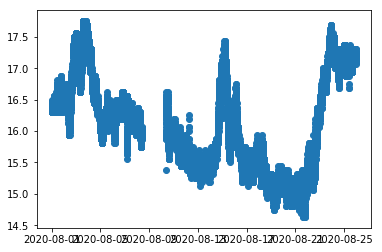

In [71]:
s2 = s1[s1['attribute'] == 'aquabyte_smooth_sensors_sea_temperature_celsius']

plt.scatter(s2.ts, s2.value)

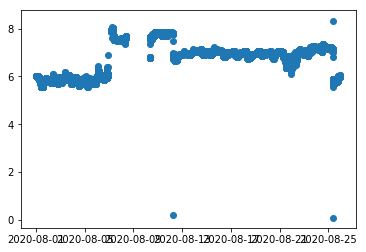

In [72]:
s2 = s1[s1['attribute'] == 'aquabyte_smooth_sensors_depth_meters']

plt.scatter(s2.ts, s2.value)

0.9684099261397212


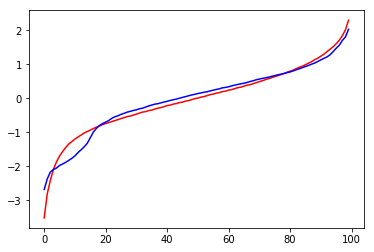

In [16]:
import scipy.stats as stats

def get_norm_pct(dist, pct):
    percentile = np.percentile(dist, pct)
    return (percentile - np.mean(dist)) / np.std(dist)

gt = []
actual = []

for pct in np.arange(0, 100, 1):
    gt.append(get_norm_pct(pen5['weight'], pct))
    actual.append(get_norm_pct(df1['estimated_weight_g'], pct))

plt.plot(sorted(gt), color = 'red')
plt.plot(sorted(actual), color = 'blue')

res = stats.ks_2samp(gt, actual)
pvalue = res.pvalue
print(pvalue)    

In [351]:
counts = []

for index, date in enumerate(dates):
    mask = df1['date'] == date
    
    for hour in sorted(list(set(df1[mask]['hour']))):
        mask2 = (df1['date'] == date) & (df1['hour'] == hour)
        
        counts.append(sum(mask2))
        
counts = np.array(counts)

In [378]:
dates = sorted(list(set(df1['date'])))

quality_score = []

for index, date in enumerate(dates):
    mask = df1['date'] == date
        
    for hour in sorted(list(set(df1[mask]['hour']))):
        
        raw_quality = qdf1[(qdf1['date'] == date) & (qdf1['hour'] == hour)]['quality_score']
        quality_score.append(np.mean(raw_quality))

quality_score = np.array(quality_score)



In [380]:
rolling_quality_score = []

for index, _ in enumerate(quality_score):
    size = 20
    start_index = max(0, index - size)
    end_index = min(quality_score.shape[0], index + size)
    
    rolling_quality_score.append(np.mean(quality_score[start_index:end_index]))

In [383]:
rolling_counts = []

for index, _ in enumerate(counts):
    size = 20
    start_index = max(0, index - size)
    end_index = min(counts.shape[0], index + size)
    
    rolling_counts.append(np.mean(counts[start_index:end_index]))

In [341]:
dates = sorted(list(set(df1['date'])))

# hours = []
# counts = []
# temps = []
# depths = []
# indicator = []
dindicator = []
dhindicator = []
dcounts = []
dhcounts = []

gt = []

a = None

for pct in np.arange(0, 100, 1):
    gt.append(get_norm_pct(pen5['weight'], pct))
    
for index, date in enumerate(dates):
    mask = df1['date'] == date
    
    dactual = []
    dhactual = []
    
    mask3 = mask & (df1['hour'] >= 5) & (df1['hour'] <= 17)
    
    for pct in np.arange(0, 100, 1):
        dactual.append(get_norm_pct(df1[mask]['estimated_weight_g'], pct))
        dhactual.append(get_norm_pct(df1[mask3]['estimated_weight_g'], pct))
        
        dres = stats.ks_2samp(gt, dactual)
        dpvalue = dres.pvalue
        dhres = stats.ks_2samp(gt, dhactual)
        dhpvalue = dhres.pvalue
        
        
    for hour in sorted(list(set(df1[mask]['hour']))):
#         mask2 = (df1['date'] == date) & (df1['hour'] == hour)
        
#         mask3 = (s1['date'] == date) & (s1['hour'] == hour)
        
#         hours.append(index * 24 + hour)
#         counts.append(sum(mask2))
        
#         s2 = s1[mask3]
        
#         raw_temps = s2[s2['attribute'] == 'aquabyte_smooth_sensors_sea_temperature_celsius']['value'].astype(float).dropna()
#         raw_depths = s2[s2['attribute'] == 'aquabyte_smooth_sensors_depth_meters']['value'].astype(float).dropna()
        
#         temps.append(np.mean(raw_temps))
#         depths.append(np.mean(raw_depths))
        
#         actual = []

#         for pct in np.arange(0, 100, 1):
#             actual.append(get_norm_pct(df1[mask2]['estimated_weight_g'], pct))

#         res = stats.ks_2samp(gt, actual)
#         pvalue = res.pvalue
#         indicator.append(pvalue)
        
        dcounts.append(sum(mask))
        dhcounts.append(sum(mask3))
        dindicator.append(dpvalue)
        dhindicator.append(dhpvalue)

# hours = np.array(hours)
# counts = np.array(counts)
# temps = np.array(temps)
# depths = np.array(depths)
# indicator = np.array(indicator)
dindicator = np.array(dindicator)
dhindicator = np.array(dhindicator)
dcounts = np.array(dcounts)
dhcounts = np.array(dhcounts)



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [317]:
len(counts), len(hours)

(1826, 1826)

In [227]:
rolling_indicator = []

for index, _ in enumerate(indicator):
    size = 20
    start_index = max(0, index - size)
    end_index = min(indicator.shape[0], index + size)
    
    rolling_indicator.append(np.mean(indicator[start_index:end_index]))

In [318]:
rolling_indicator2 = []
rolling_counts2 = []

for index, _ in enumerate(indicator):
    size = 20
    start_index = max(0, index - size)
    end_index = min(indicator.shape[0], index + size)
    
    hour_subset = hours[start_index:end_index] % 24
    mask = (hour_subset >= 5) & (hour_subset <= 17)
    
    rolling_indicator2.append(np.mean(indicator[start_index:end_index][mask]))
    rolling_counts2.append(np.sum(counts[start_index:end_index][mask]))

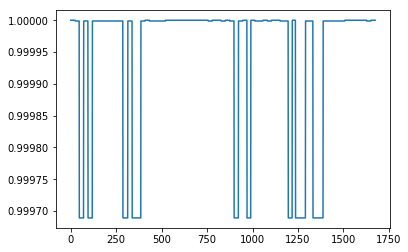

In [339]:
plt.plot(dhindicator[mask2])

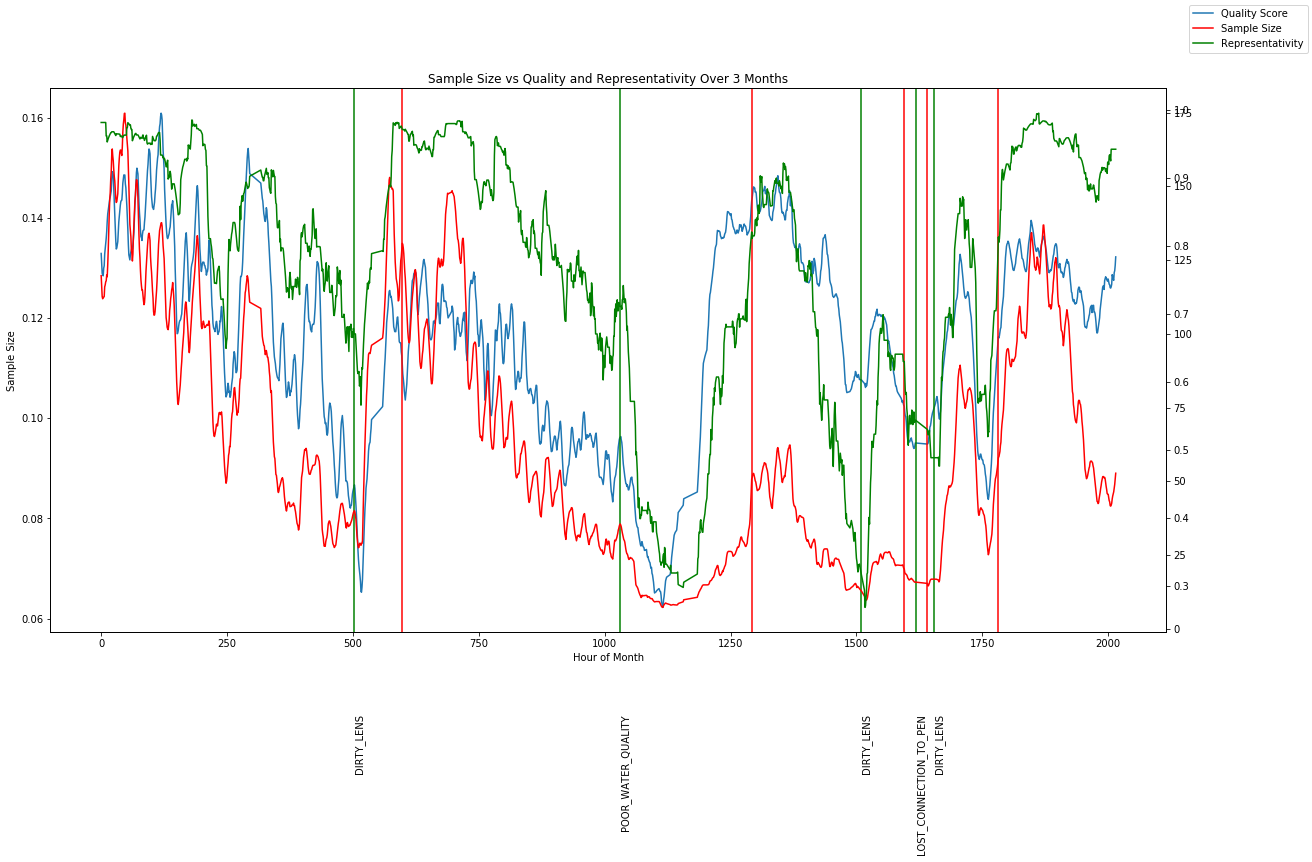

In [387]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax1 = ax.twinx()
ax2 = ax.twinx()
                       
ax.plot(hours, rolling_quality_score, label = 'Quality Score')
# ax1.plot(hours, depths, color = 'red', label = 'Depth')
ax1.plot(hours, rolling_counts, color = 'red', label = 'Sample Size')

# mask2 = dhindicator > 0.995

ax2.plot(hours, rolling_indicator2, color = 'green', label = 'Representativity')
ax.set_xlabel('Hour of Month')
ax.set_ylabel('Quality Score')
ax.set_ylabel('Sample Size')
ax.set_title('Sample Size vs Quality and Representativity Over 3 Months')

for index, event_start_hour in enumerate(start_hours):
    ax.axvline(x=event_start_hour, color = 'green')
    plt.text(event_start_hour, 0.1, event_name[index],rotation=90)
for event_start_hour in end_hours:
    ax.axvline(x=event_start_hour, color = 'red')


    
lines = []
labels = []

for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    
fig.legend(lines, labels,           
           loc = 'upper right')

391 1826


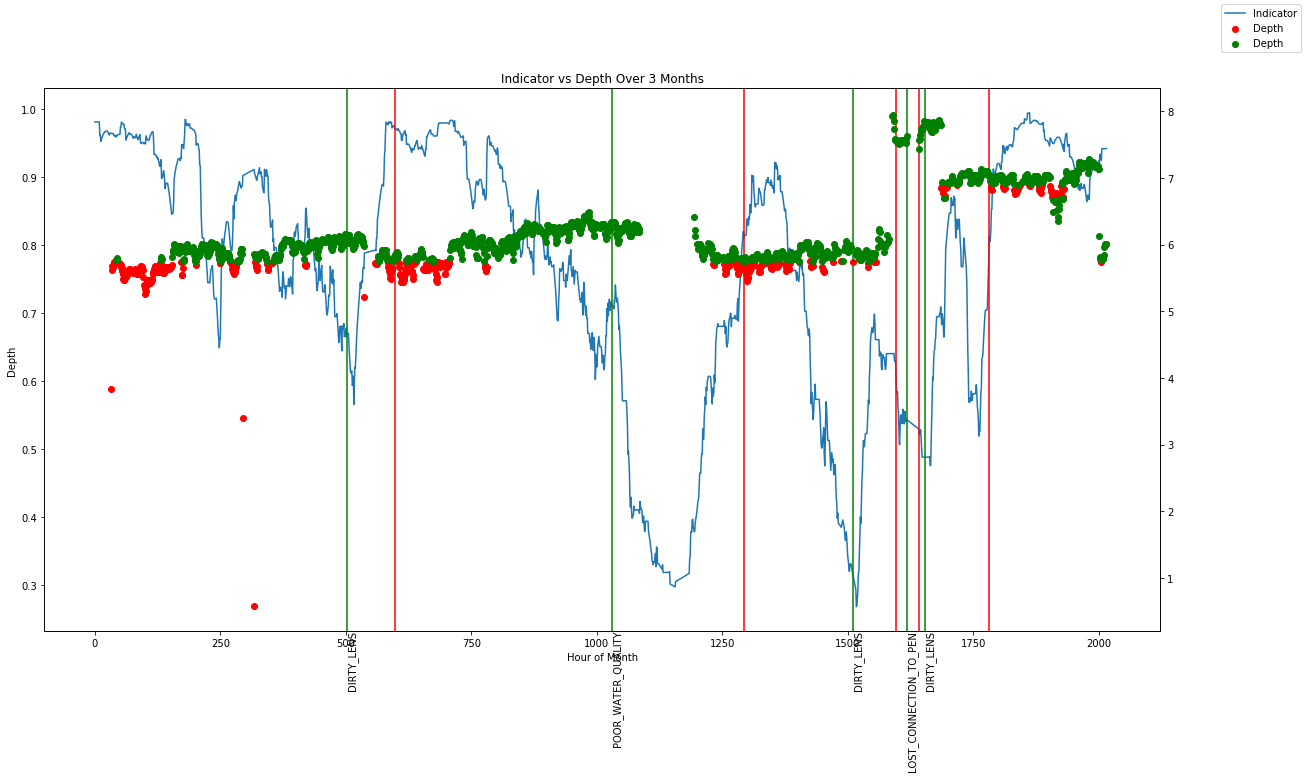

In [311]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax1 = ax.twinx()
                       
ax.plot(hours, rolling_indicator2, label = 'Indicator')

mask = (depths < 5.75) | ((depths > 6.7) & (depths < 6.9))
print(sum(mask), len(depths))
ax1.scatter(hours[mask], depths[mask], color = 'red', label = 'Depth')
ax1.scatter(hours[~mask], depths[~mask], color = 'green', label = 'Depth')
ax.set_xlabel('Hour of Month')
ax.set_ylabel('Indicator')
ax.set_ylabel('Depth')
ax.set_title('Indicator vs Depth Over 3 Months')


for index, event_start_hour in enumerate(start_hours):
    ax.axvline(x=event_start_hour, color = 'green')
    plt.text(event_start_hour, 0.1, event_name[index],rotation=90)
for event_start_hour in end_hours:
    ax.axvline(x=event_start_hour, color = 'red')

lines = []
labels = []

for ax in fig.axes:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)

    
fig.legend(lines, labels,           
           loc = 'upper right')

In [294]:
hours[480]

503

In [296]:
master_indices = [0, 470]

dfs = []

for master_index in master_indices:
    for index, date in enumerate(dates):
        mask = df1['date'] == date

        for hour in sorted(list(set(df1[mask]['hour']))):
            if index * 24 + hour == master_index:
                print(date, hour)
                dfs.append(df1[mask])

2020-06-01 0
2020-06-21 14


In [297]:
len(dfs)

2

In [298]:
def get_norm_dist(dist):
    return (dist - np.mean(dist)) / np.std(dist)

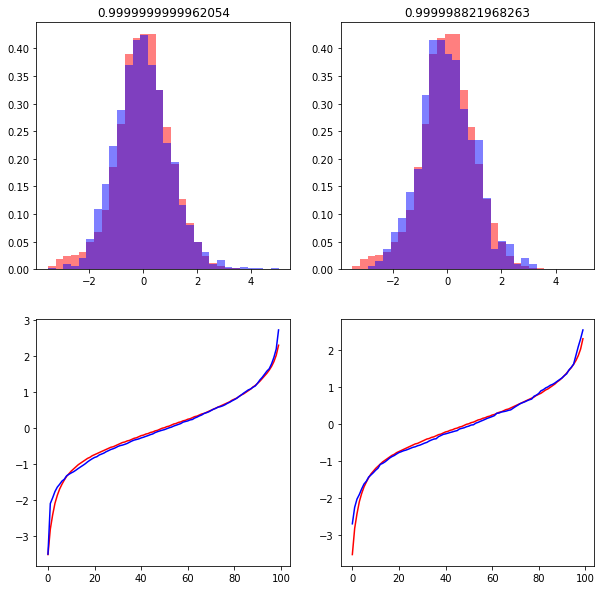

In [340]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

for index, df in enumerate(dfs):
    mask = (df['hour'] >= 5) & (df['hour'] <= 17)
    counts, bins, _ = ax[0, index].hist(get_norm_dist(pen5['weight']), density = True, alpha = 0.5, color = 'red', bins = 30)
    ax[0, index].hist(get_norm_dist(df[mask]['estimated_weight_g']), density = True, alpha = 0.5, color = 'blue', bins = bins)
    
    gt = []
    actual = []

    for pct in np.arange(0, 100, 1):
        gt.append(get_norm_pct(pen5['weight'], pct))
        actual.append(get_norm_pct(df[mask]['estimated_weight_g'], pct))

    ax[1, index].plot(sorted(gt), color = 'red')
    ax[1, index].plot(sorted(actual), color = 'blue')

    res = stats.ks_2samp(gt, actual)
    pvalue = res.pvalue
    
    ax[0, index].set_title(pvalue)

Text(0.5, 1.0, 'Depth Over 3 Months')

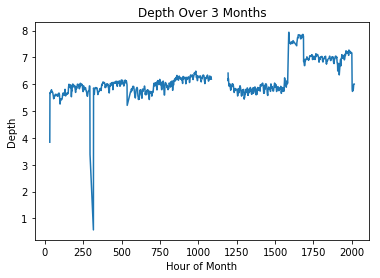

In [156]:
plt.plot(hours, depths)
plt.xlabel('Hour of Month')
plt.ylabel('Depth')
plt.title('Depth Over 3 Months')

In [164]:
temps

array([        nan,         nan,         nan, ..., 17.23576271,
       17.19306122, 17.18931034])

In [165]:
tempmask = ~np.isnan(temps) & (temps > 8)

raw_temps = np.array([ int(temp * 100) for temp in temps[tempmask] ])
raw_hours = np.array([ hour % 24 for hour in hours ])[tempmask]

temp_list = sorted(list(set(raw_temps)))
mean_indicator_by_temp = []
median_indicator_by_temp = []
counts_by_temp = []

for temp in temp_list:
    mean_indicator_by_temp.append(np.mean(indicator[tempmask][raw_temps == temp]))
    median_indicator_by_temp.append(np.median(indicator[tempmask][raw_temps == temp]))
    counts_by_temp.append(np.mean(counts[tempmask][raw_temps == temp]))

Text(0.5, 1.0, 'Hour vs Temperature')

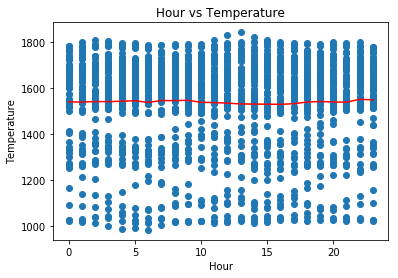

In [166]:
hour_list = np.array(sorted(list(set(raw_hours))))

avg_temps = []

for hour in hour_list:
    avg_temps.append(np.mean(raw_temps[raw_hours == hour]))

plt.scatter(raw_hours, raw_temps)
plt.plot(hour_list, avg_temps, color = 'red')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Hour vs Temperature')

Text(0.5, 1.0, 'Hour vs Avg Temperature')

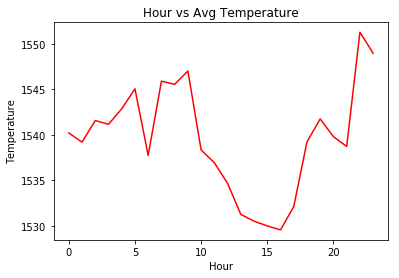

In [182]:
plt.plot(hour_list, avg_temps, color = 'red')
plt.xlabel('Hour')
plt.ylabel('Temperature')
plt.title('Hour vs Avg Temperature')

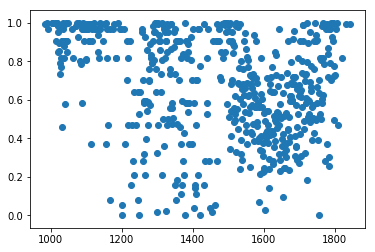

In [168]:
plt.scatter(temp_list, mean_indicator_by_temp)

[-0.00032571] 0.07885635306362837


Text(0.5, 1.0, 'Temperature vs Representativity Indicator')

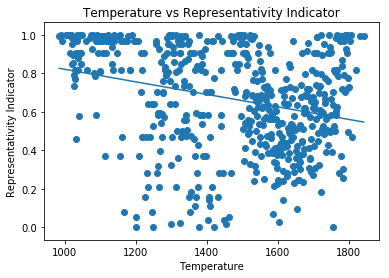

In [169]:
from sklearn.linear_model import LinearRegression

X = np.array(temp_list).reshape(-1, 1)
y = np.array(mean_indicator_by_temp)

reg = LinearRegression().fit(X, y)

print(reg.coef_, reg.score(X, y))

plt.scatter(temp_list, mean_indicator_by_temp)
plt.plot(temp_list, reg.predict(X))
plt.xlabel('Temperature')
plt.ylabel('Representativity Indicator')
plt.title('Temperature vs Representativity Indicator')

In [200]:
depthmask = ~np.isnan(depths) & (depths > 5)

raw_depths = np.array([ int(depth * 100) for depth in depths[depthmask] ])

depth_list = np.array(sorted(list(set(raw_depths))))
mean_indicator_by_depth = []
median_indicator_by_depth = []
counts_by_depth = []

for depth in depth_list:
    mean_indicator_by_depth.append(np.mean(indicator[depthmask][raw_depths == depth]))
    median_indicator_by_depth.append(np.median(indicator[depthmask][raw_depths == depth]))
    counts_by_depth.append(np.mean(counts[depthmask][raw_depths == depth]))

mean_indicator_by_depth = np.array(mean_indicator_by_depth)

55 199


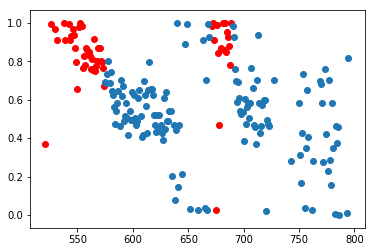

In [264]:
mask = (depth_list < 575) | ((depth_list > 670) & (depth_list < 690))
print(sum(mask), len(mask))
plt.scatter(depth_list[mask], mean_indicator_by_depth[mask], color = 'red')
plt.scatter(depth_list[~mask], mean_indicator_by_depth[~mask])

[-0.00144627] 0.17813541585768985


Text(0.5, 1.0, 'Depth vs Representativity Indicator')

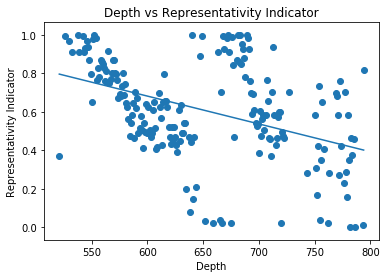

In [174]:
from sklearn.linear_model import LinearRegression

X = np.array(depth_list).reshape(-1, 1)
y = np.array(mean_indicator_by_depth)

reg = LinearRegression().fit(X, y)

print(reg.coef_, reg.score(X, y))

plt.scatter(depth_list, mean_indicator_by_depth)
plt.plot(depth_list, reg.predict(X))
plt.xlabel('Depth')
plt.ylabel('Representativity Indicator')
plt.title('Depth vs Representativity Indicator')

In [175]:
raw_days = np.array([ int(hour / 24) for hour in hours ])

day_list = sorted(list(set(raw_days)))
mean_indicator_by_day = []
median_indicator_by_day = []
counts_by_day = []

for day in day_list:
    mean_indicator_by_day.append(np.mean(indicator[raw_days == day]))
    median_indicator_by_day.append(np.median(indicator[raw_days == day]))
    counts_by_day.append(np.mean(counts[raw_days == day]))

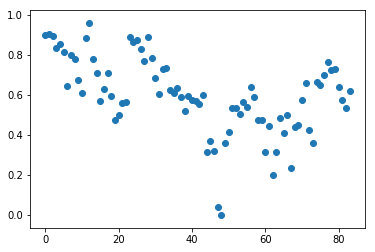

In [176]:
plt.scatter(day_list, mean_indicator_by_day)

[-0.00393825] 0.24804985486028996


Text(0.5, 1.0, 'Days before Harvest vs Representativity Indicator')

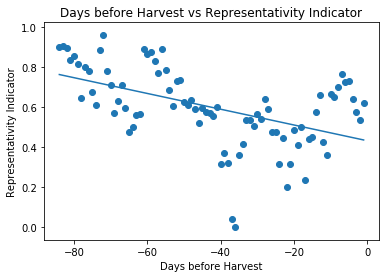

In [177]:
from sklearn.linear_model import LinearRegression

X = np.array(day_list).reshape(-1, 1)
y = np.array(mean_indicator_by_day)

reg = LinearRegression().fit(X, y)

print(reg.coef_, reg.score(X, y))

plt.scatter(np.array(day_list) - len(day_list), mean_indicator_by_day)
plt.plot(np.array(day_list) - len(day_list), reg.predict(X))
plt.xlabel('Days before Harvest')
plt.ylabel('Representativity Indicator')
plt.title('Days before Harvest vs Representativity Indicator')

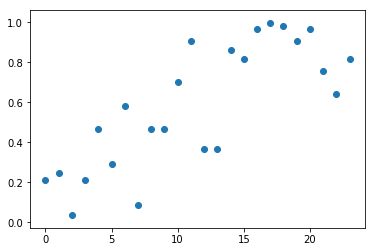

In [54]:
plt.scatter(day_list, median_indicator_by_day)

<BarContainer object of 24 artists>

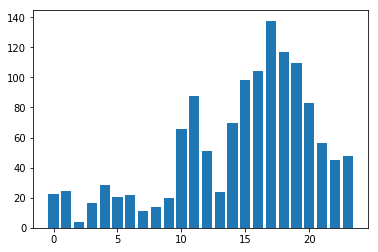

In [52]:
plt.bar(day_list, counts_by_day)

In [178]:
raw_hours = np.array([ hour % 24 for hour in hours ])

hour_list = sorted(list(set(raw_hours)))
mean_indicator_by_hour = []
median_indicator_by_hour = []
counts_by_hour = []

for hour in hour_list:
    mean_indicator_by_hour.append(np.mean(indicator[raw_hours == hour]))
    median_indicator_by_hour.append(np.median(indicator[raw_hours == hour]))
    counts_by_hour.append(np.mean(counts[raw_hours == hour]))

<BarContainer object of 24 artists>

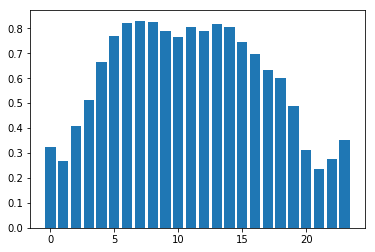

In [179]:
plt.bar(hour_list, mean_indicator_by_hour)

Text(0.5, 1.0, 'Hour vs Representativity Indicator')

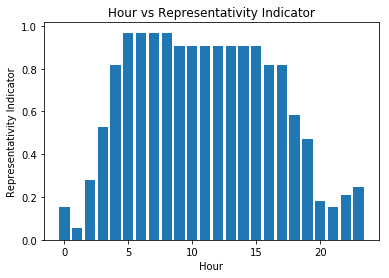

In [180]:
plt.bar(hour_list, median_indicator_by_hour)
plt.xlabel('Hour')
plt.ylabel('Representativity Indicator')
plt.title('Hour vs Representativity Indicator')

Text(0.5, 1.0, 'Hour vs Number of Samples')

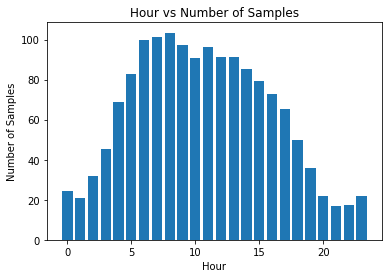

In [181]:
plt.bar(hour_list, counts_by_hour)
plt.xlabel('Hour')
plt.ylabel('Number of Samples')
plt.title('Hour vs Number of Samples')

<BarContainer object of 513 artists>

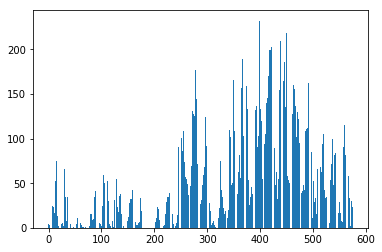

In [27]:
plt.bar(hours, counts)

<BarContainer object of 228 artists>

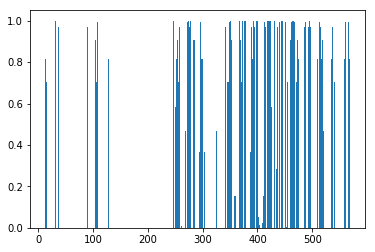

In [36]:
plt.bar(hours[counts >= 50], indicator[counts >= 50])

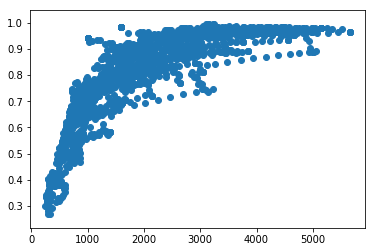

In [319]:
plt.scatter(rolling_counts2, rolling_indicator2)

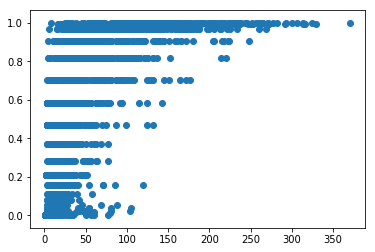

In [352]:
plt.scatter(counts, indicator)

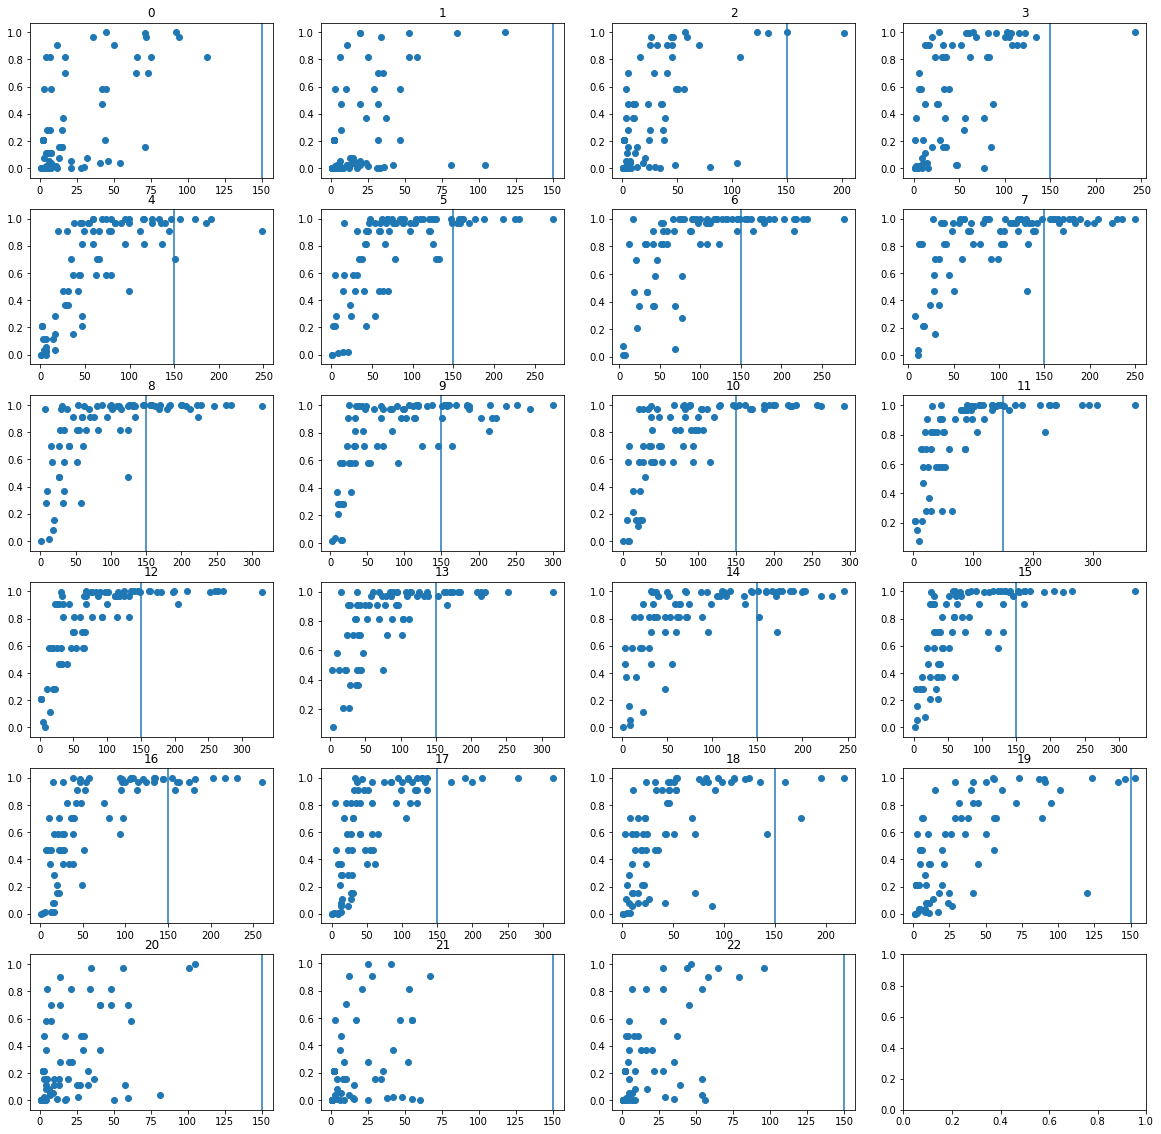

In [359]:
raw_hours = np.array([ hour % 24 for hour in hours ])

fig, ax = plt.subplots(6, 4, figsize=(20, 20))

for hour in np.arange(0, 23):
    mask = (raw_hours == hour)

    ax[int(hour / 4), hour % 4].scatter(counts[mask], indicator[mask])
    ax[int(hour / 4), hour % 4].set_title(hour)
    ax[int(hour / 4), hour % 4].axvline(x=150)

Text(0.5, 1.0, 'Count vs Representativity')

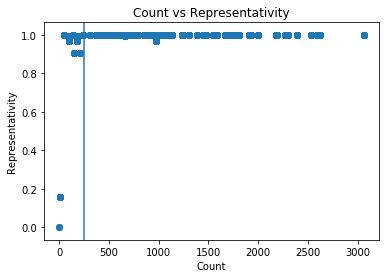

In [361]:
plt.scatter(dhcounts, dhindicator)
plt.axvline(x=250)
plt.xlabel('Count')
plt.ylabel('Representativity')
plt.title('Count vs Representativity')

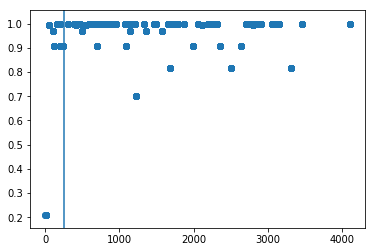

In [347]:
plt.scatter(dcounts, dindicator)
plt.axvline(x=250)